# Lee-Six data analysis

In [1]:
using Revise
using DelimitedFiles
using Statistics
using Distributions
using Plots
gr()

Plots.GRBackend()

In [2]:
untypedM = readdlm("../data/Shearwater_calls_FDR0.95_all_muts.txt", '\t', Any; skipstart=1)
untypedM = untypedM[:, 5: end-1]
replace!(untypedM, "NA"=>0)
variants_var_col = Array{Int}(untypedM);

In [3]:
HSCMask_col = fill(false, size(variants_var_col, 2))
HSCBMMask_col = fill(false, size(variants_var_col, 2))
HSCBMMask_col[1:73] .= true
HSCMask_col[1:73] .= true
HSCMask_col[125:end] .= true
HPCMask_col = .!HSCMask_col;

In [4]:
sum(HSCMask_col)
sum(variants_var_col[:, HSCMask_col])

92274

In [5]:
mutBurden_col = sum(variants_var_col, dims=1);

In [6]:
include("../src/vafdyn.jl")
using .VAFDyn

In [7]:
vaf_var = sum(variants_var_col, dims=2) / 140
vafHSC_var = sum(variants_var_col[:, HSCMask_col], dims=2);
vafHPC_var = sum(variants_var_col[:, HPCMask_col], dims=2) / sum(HPCMask_col);

vafHSCBM_var = sum(variants_var_col[:, HSCBMMask_col], dims=2) / sum(HSCBMMask_col)

vafAbsHSC_var = sum(variants_var_col[:, HSCMask_col], dims=2);
vafAbsHSCBM_var = sum(variants_var_col[:, HSCBMMask_col], dims=2);

In [8]:
function makeHist(varPrev_var, N::Integer)
    n_f = zeros(Int64, N+1)
    for m in 1:N
        n_f[1+m] = length(findall(x -> x==m, varPrev_var))
    end
    return n_f
end

vafHSC_f = makeHist(vafAbsHSC_var, sum(HSCMask_col));
vafHSCBM_f = makeHist(vafAbsHSCBM_var, sum(HSCBMMask_col));

In [9]:
println(vafHSC_f)

[0, 78721, 3815, 972, 451, 34, 22, 16, 2, 8, 8, 11, 3, 2, 2, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 4, 1, 2, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [10]:
function sampler(nTrue_f, N::Integer, S::Integer; sMax::Union{Integer, Nothing}=nothing)
    if isnothing(sMax)
        sMax = S
    elseif !(0 < sMax < S)
        println("error: sMax should be between 1 and sample size; setting sMax = s.")
        sMax = S
    end

    nSamp_f = Vector{Float64}(undef, S+1)
    for u in 1:sMax
        nSamp_f[1+u] =
            sum(
                [ nTrue_f[1+v] * pdf(Hypergeometric(v, N-v, S), u)
                for v=1:N ]
            )
    end
    return nSamp_f
end

sampler (generic function with 1 method)

In [70]:
nTrueEstimate = 3000

vafTrueEq_f = (2+1)*4.2 ./ ((0:nTrueEstimate)/nTrueEstimate);

vafSampEq_f = sampler(vafTrueEq_f, nTrueEstimate, sum(HSCMask_col));

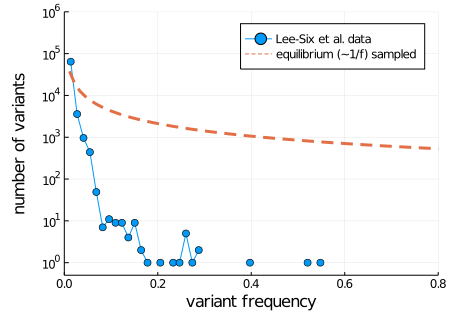

number of HSC cells:89


In [73]:
# p1 = histogram(vafHSC_var, yaxis=:log10, bins=sum(HSCMask_col), 
#         ylims=(10^-0.3, 10^5), xlims=(0, 0.6), label="HSC", fillalpha=0.5, linealpha=0.4)
p1 = plot(range(0,1; length=sum(HSCBMMask_col)+1), vafHSCBM_f,
        yaxis=:log10,
        size=(450,320),
        fontsize=22,
        linewidth=1,
        markershape=:circle,
        label="Lee-Six et al. data")
plot!(range(0,1; length=length(vafSampEq_f))[2:end], vafSampEq_f[2:end],
        linewidth=3,
        linestyle=:dash,
        label="equilibrium (~1/f) sampled")
xlims!(0, 0.8)
ylims!(10^-0.3, 10^6)
xlabel!("variant frequency")
ylabel!("number of variants")
# title!("HSC")
display(p1)
println("number of HSC cells:", sum(HSCMask_col))

# savefig(p1, "../figures/LSData_VAFEqCompare.pdf")

In [19]:
mutHSCAv = mean(mutBurden_col[HSCMask_col])
mutHPCAv = mean(mutBurden_col[HPCMask_col])

mutHSCVar = var(mutBurden_col[HSCMask_col])
mutHPCVar = var(mutBurden_col[HPCMask_col])

mutDistHSC = fit(Poisson, mutBurden_col[HSCMask_col])
mutDistHPC = fit(Poisson, mutBurden_col[HPCMask_col])

display(mutDistHSC)
display(mutDistHPC)

Poisson{Float64}(λ=1036.7865168539327)

Poisson{Float64}(λ=1056.9607843137255)

In [75]:
testa = [10,10,4,6,8,12,17,24]

sum(testa[(testa .>= 10) .& (testa .<= 20)])

49

In [82]:
Bool.(mutBurden_col .> 880)

1×140 BitArray{2}:
 1  1  1  1  1  1  1  1  1  1  1  1  1  …  0  1  1  1  1  1  0  1  1  1  1  1

In [94]:
mutBurdenHSC_col = mutBurden_col[HSCMask_col]

mutHSCAltAv = mean(mutBurdenHSC_col[mutBurdenHSC_col .> 880])
mutHSCAltVar = var(mutBurdenHSC_col[mutBurdenHSC_col .> 880])
mutDistHSCAlt = fit(Poisson, mutBurdenHSC_col[mutBurdenHSC_col .> 880])

display(mutDistHSCAlt)

Poisson{Float64}(λ=1043.8139534883721)

In [95]:
mutBurdenHSCBM_col = mutBurden_col[HSCBMMask_col]

mutHSCBMAv = mean(mutBurdenHSCBM_col)
mutHSCBMVar = var(mutBurdenHSCBM_col)
mutDistHSCBM = fit(Poisson, mutBurdenHSCBM_col)


Poisson{Float64}(λ=1055.2054794520548)

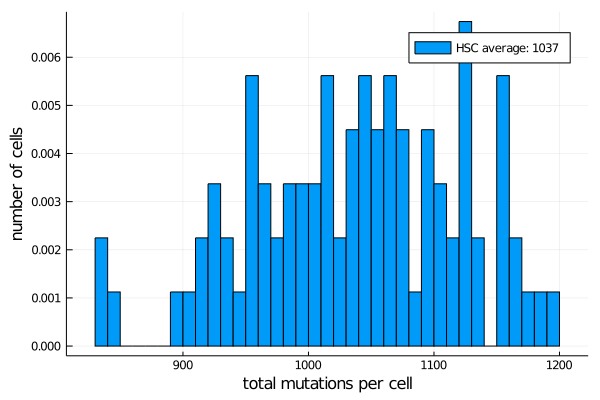

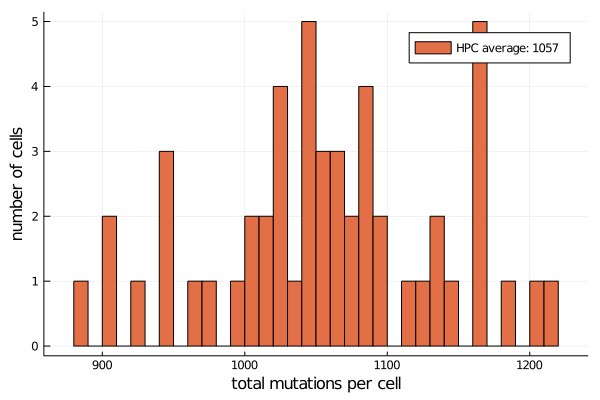

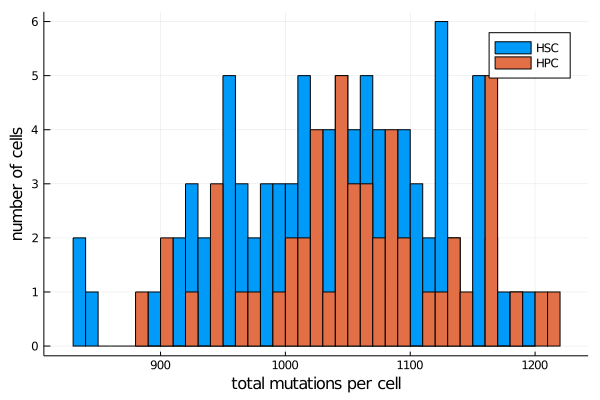

In [20]:
# ===== plot single cell(/colony) mutational burden =====

h1 = histogram(mutBurden_col[HSCMask_col], normalize=true, bins=40, 
    label="HSC average: "*string(Integer(round(mutHSCAv))))
xlabel!("total mutations per cell")
ylabel!("number of cells")
display(h1)

h2 = histogram(mutBurden_col[HPCMask_col], bins=40, 
    label="HPC average: "*string(Integer(round(mutHPCAv))), color=2)
xlabel!("total mutations per cell")
ylabel!("number of cells")
display(h2)

h3 = histogram(mutBurden_col[HSCMask_col], bins=40, label="HSC")
histogram!(mutBurden_col[HPCMask_col], bins=40, label="HPC")
xlabel!("total mutations per cell")
ylabel!("number of cells")
display(h3)

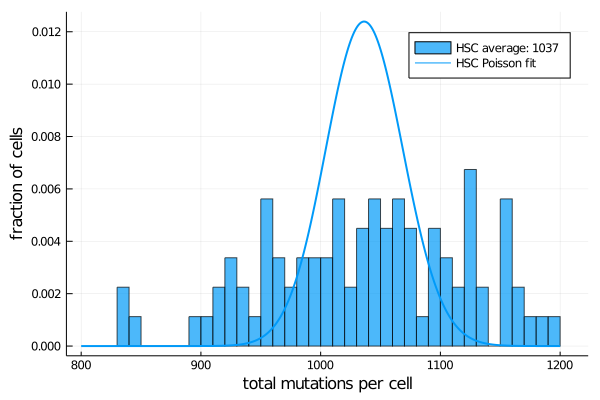

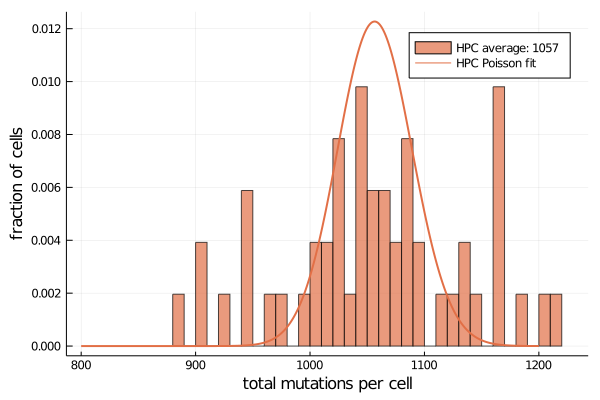

In [21]:
# ===== plot single cell(/colony) mutational burden =====

h1 = histogram(mutBurden_col[HSCMask_col], normalize=true, bins=40, 
    label="HSC average: "*string(Integer(round(mutHSCAv))), alpha=0.7)
plot!(800:1200, pdf.(mutDistHSC, 800:1200), label="HSC Poisson fit", color=1, linewidth=2)
xlabel!("total mutations per cell")
ylabel!("fraction of cells")
display(h1)

h2 = histogram(mutBurden_col[HPCMask_col], normalize=true, bins=40, 
    label="HPC average: "*string(Integer(round(mutHPCAv))), alpha=0.7, color=2)
plot!(800:1200, pdf.(mutDistHPC, 800:1200), label="HPC Poisson fit", color=2, linewidth=2)
xlabel!("total mutations per cell")
ylabel!("fraction of cells")
display(h2)

In [22]:
function randComPois(λ::Real, μ::Real, nSamples)
    Pλ = Poisson(λ)
    Pμ = Poisson(μ)
    n_s = rand(Pλ, nSamples)
    Y_s = sum.(rand.(Pμ, n_s))
end

randComPois (generic function with 1 method)

In [27]:
μm = 1.2/2
t = 59
λm = mutHSCAv/(t*μm)

println(λm)

@time comPoisData = randComPois(λm*t, μm, 10000);

29.28775471338793
 65.245209 seconds (1.00 M allocations: 13.035 GiB, 5.02% gc time)


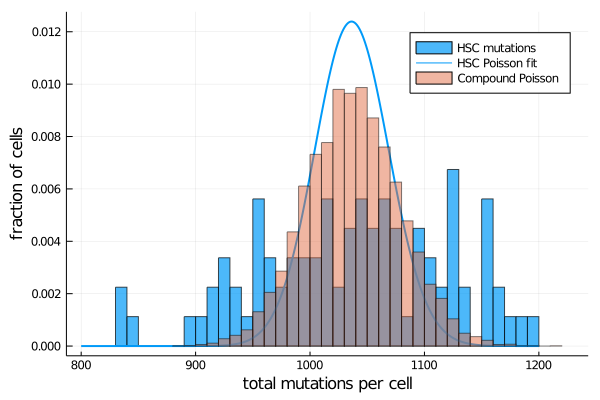

In [24]:
h1 = histogram(mutBurden_col[HSCMask_col], normalize=true, bins=40, 
    label="HSC mutations", alpha=0.7)
plot!(800:1200, pdf.(mutDistHSC, 800:1200), label="HSC Poisson fit", color=1, linewidth=2)
histogram!(comPoisData, normalize=true, bins=40, label="Compound Poisson", color=2, alpha=0.5)
xlabel!("total mutations per cell")
ylabel!("fraction of cells")
display(h1)

# savefig(h1, "LS_singleCellMutBurden.pdf")

We can fit $lambda$ and $\mu$ to the data using the mean and variance of the compound Poisson distribution:
\begin{align}
    E(m) &= \lambda t \mu \\
    Var(m) &= \lambda t (\mu + \mu^2)
\end{align}

In [100]:
mVar = mutHSCVar
mAv = mutHSCAv

mVar = mutHSCBMVar
mAv = mutHSCBMAv

println(mAv)
println(mVar)

λ = mAv^2/((mVar-mAv)*t)
μ = (mVar-mAv)/mAv

println("λ: "*string(λ))
println("μ: "*string(μ))

@time comPoisData = randComPois(λ*t, μ, 10^6 + 1);

1055.2054794520548
5583.471080669711
λ: 4.167639751842632
μ: 4.291359066453186
 24.239901 seconds (1.00 M allocations: 1.993 GiB, 5.35% gc time)


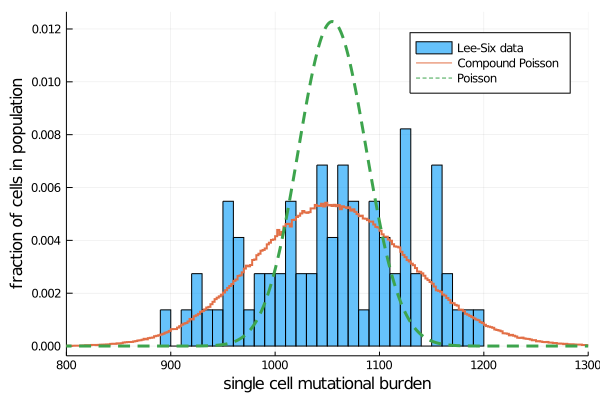

In [103]:
h1 = histogram(mutBurdenHSCBM_col, normalize=true, bins=40, 
    label="Lee-Six data",
    fillalpha=0.6,
#     legend=:topleft,
    linewidth=1)
histogram!(comPoisData, normalize=true, bins=500, 
    label="Compound Poisson", linewidth=2)
plot!(700:1300, pdf.(mutDistHSCBM, 700:1300), label="Poisson", linewidth=3, linestyle=:dash)
xlims!(800, 1300)
xlabel!("single cell mutational burden")
ylabel!("fraction of cells in population")
display(h1)

savefig(h1, "LS_singleCellMutBurdenFit.pdf")